In [1]:
import numpy as np
import pandas as pd

# for reproducibility
np.random.seed(42)

persons = ['Person1', 'Person2', 'Person3']
n_samples = 30

data = []
for idx, person in enumerate(persons):
    # set different true-value distributions, but close enough to overlap
    true_mean = 10 + idx * 2        # means: 10, 12, 14
    true_sd   = 1.5
    noise_sd  = 2.0                 # prediction noise
    
    # generate “true” and “pred” pairs
    true_vals = np.random.normal(loc=true_mean, scale=true_sd, size=n_samples)
    pred_vals = true_vals + np.random.normal(loc=0, scale=noise_sd, size=n_samples)
    
    for day_id, (t, p) in enumerate(zip(true_vals, pred_vals), start=1):
        data.append({
            'person_id': person,
            'day_id':    day_id,
            'true':      t,
            'pred':      p
        })

# assemble into a DataFrame
df = pd.DataFrame(data)

# quick sanity check
print(df.groupby('person_id')[['true','pred']].agg(['mean','std']).round(2))


            true         pred      
            mean   std   mean   std
person_id                          
Person1     9.72  1.35   9.48  2.41
Person2    12.02  1.49  11.98  2.18
Person3    13.86  1.54  14.42  2.12


In [2]:
df

,person_id,day_id,true,pred
0,Person1,1,10.745071,9.541658
1,Person1,2,9.792604,13.497160
2,Person1,3,10.971533,10.944538
3,Person1,4,12.284545,10.169123
4,Person1,5,9.648770,11.293860
...,...,...,...,...
85,Person3,26,15.172734,16.827101
86,Person3,27,12.144574,12.170578
87,Person3,28,12.019315,14.926383
88,Person3,29,14.782912,14.253599


In [20]:
import numpy as np
import pandas as pd

# 1) Set up reproducibility and parameters
np.random.seed(42)
persons   = ['Person1', 'Person2', 'Person3']
n_samples = 30

# choose well‐separated raw means
raw_means = [ 8, 10, 12 ]
sd_true   = 1.0   # spread of true values
sd_noise  = 2.0   # noise for pred

# 2) Generate the raw data
rows = []
for person, μ in zip(persons, raw_means):
    # a) true values around μ
    raw_t = np.random.normal(loc=μ, scale=sd_true, size=n_samples)
    # b) noise, then center it so each group's pred_mean == μ exactly
    noise = np.random.normal(loc=0, scale=sd_noise, size=n_samples)
    noise_centered = noise - noise.mean()
    raw_p = μ + noise_centered
    
    for day, (t, p) in enumerate(zip(raw_t, raw_p), start=1):
        rows.append({
            'person_id': person,
            'day_id':    day,
            'true':      t,
            'pred':      p
        })

df = pd.DataFrame(rows)

# 3) Min–max scale both columns into [1, 5]
for col in ['true', 'pred']:
    mn, mx = df[col].min(), df[col].max()
    df[col] = 1 + (df[col] - mn) / (mx - mn) * (5 - 1)

# 4) Sanity checks
print("Within-person correlations (should be near 0):")
for p in persons:
    sub = df[df['person_id'] == p]
    print(f"  {p}:  {sub['true'].corr(sub['pred']):.3f}")

means = df.groupby('person_id').agg(
    true_mean = ('true','mean'),
    pred_mean = ('pred','mean'),
)
bw_corr = means['true_mean'].corr(means['pred_mean'])
print(f"\nBetween-person correlation of the means (should be high): {bw_corr:.3f}")

# df is now ready for your plotting code!


Within-person correlations (should be near 0):
  Person1:  0.099
  Person2:  -0.143
  Person3:  -0.249

Between-person correlation of the means (should be high): 0.999


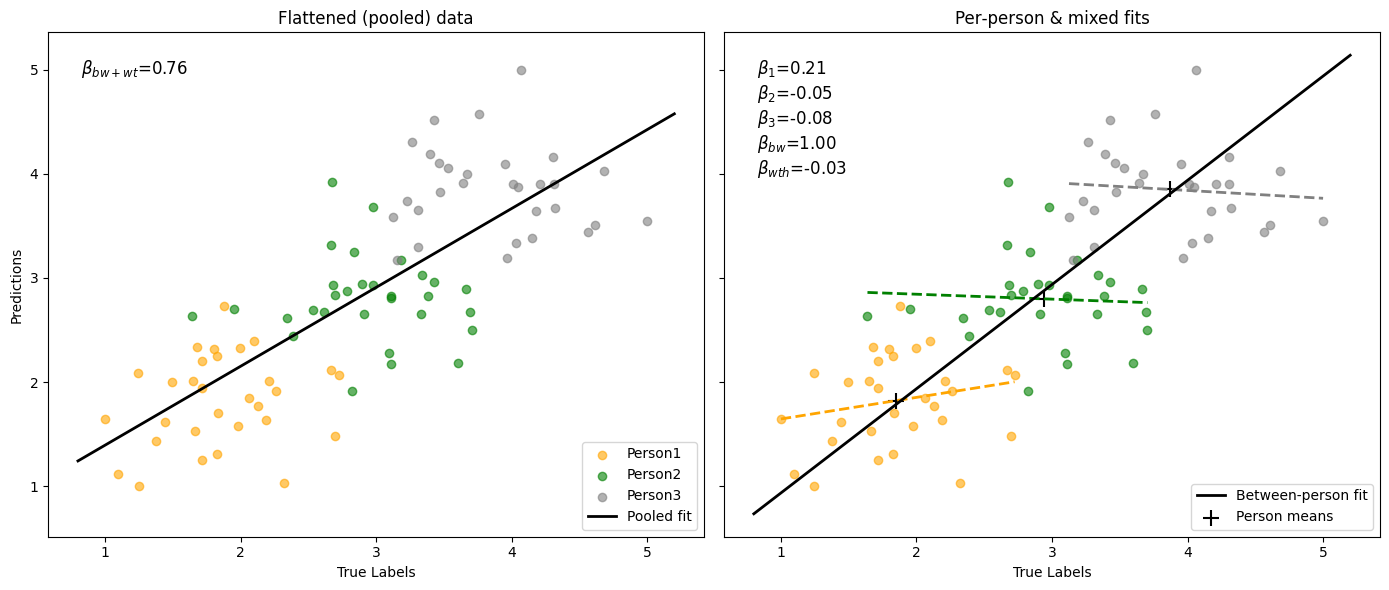

In [59]:
import matplotlib.pyplot as plt
from scipy import stats

# --- assume df is your DataFrame with columns: person_id, day_id, true, pred

# pick your three colors
palette = ['orange', 'green', 'gray']

# get sorted list of people
persons = sorted(df['person_id'].unique())
# map each person → a color
color_map = {p: palette[i] for i,p in enumerate(persons)}

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharex=True, sharey=True)

# ----------------------
# 1) Flattened / pooled
# ----------------------
ax = axes[0]
for p in persons:
    sub = df[df['person_id'] == p]
    ax.scatter(sub['true'], sub['pred'],
               color=color_map[p],
               alpha=0.6,
               label=str(p))

# overall (between+within) regression on *all* points
s_all, i_all, r_all, _, _ = stats.linregress(df['true'], df['pred'])
x0, x1 = ax.get_xlim()
xx = np.array([x0, x1])
yy = i_all + s_all * xx
ax.plot(xx, yy, color='black', linewidth=2, label='Pooled fit')

ax.set_title("Flattened (pooled) data")
ax.set_xlabel("True Labels")
ax.set_ylabel("Predictions")
ax.legend(loc='lower right')
ax.text(0.05, 0.95,
        rf"$\beta_{{bw+wt}}$={s_all:.2f}",
        transform=ax.transAxes, va='top', fontsize=12)

# -----------------------------------------------
# 2) Per-person fits + Between-person & Within-person
# -----------------------------------------------
ax = axes[1]
# … after setting up ax, xx/x0/x1, etc.
betas = {}
for p in persons:
    sub = df[df['person_id'] == p]
    # fit
    s_p, i_p, *_ = stats.linregress(sub['true'], sub['pred'])
    betas[p]    = s_p

    # restrict the line to each person's true‐range
    xp = np.array([sub['true'].min(), sub['true'].max()])
    yp = i_p + s_p * xp
    ax.plot(xp, yp,
            color=color_map[p],
            linestyle='--',
            linewidth=2)

    # still scatter all points
    ax.scatter(sub['true'], sub['pred'],
               color=color_map[p],
               alpha=0.6)

# --- between-person: fit on each person's MEAN
means = (df
         .groupby('person_id')
         .agg(true=('true','mean'), pred=('pred','mean'))
         .reset_index())
s_bw, i_bw, r_bw, _, _ = stats.linregress(means['true'], means['pred'])
yy_bw = i_bw + s_bw * xx
ax.plot(xx, yy_bw,
        color='black',
        linewidth=2,
        label="Between‐person fit")
ax.scatter(means['true'], means['pred'],
           marker='+', s=120, color='black',
           label="Person means")

# # --- within-person slope: regress on demeaned data
# dfc = df.copy()
# dfc['true_c'] = dfc['true'] - dfc.groupby('person_id')['true'].transform('mean')
# dfc['pred_c'] = dfc['pred'] - dfc.groupby('person_id')['pred'].transform('mean')
# s_wt, i_wt, r_wt, _, _ = stats.linregress(dfc['true_c'], dfc['pred_c'])
# yy_wt = i_wt + s_wt * xx
# ax.plot(xx, yy_wt,
#         color='black',
#         linestyle=':',
#         linewidth=2,
#         label="Within‐person fit")

# annotate all betas
txt = "\n".join([
    fr"$\beta_1$={betas[persons[0]]:.2f}",
    fr"$\beta_2$={betas[persons[1]]:.2f}",
    fr"$\beta_3$={betas[persons[2]]:.2f}",
    fr"$\beta_{{bw}}$={s_bw:.2f}",
    fr"$\beta_{{wth}}$={s_wt:.2f}",
])
ax.text(0.05, 0.95, txt,
        transform=ax.transAxes,
        va='top', fontsize=12)

ax.set_title("Per‐person & mixed fits")
ax.set_xlabel("True Labels")
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.patches import Circle


# ─── 1) DATA GENERATION ────────────────────────────────────────────────────────
np.random.seed(42)
persons    = ['Person1','Person2','Person3']
n_samples  = [30, 20, 40]
raw_means  = [1.25, 3, 4]
sd_true    = [0.5, 0.30, 0.4]
sd_noise   = [0.5, 0.5, 0.65]          # reduced noise → positive within-person corr
within_slp = [0.12, 0.08, 0.14]
fontsize_a = 16
fontsize_b = 14

rows = []
for idx, (person, μ, w) in enumerate(zip(persons, raw_means, within_slp)):
    raw_t = np.random.normal(μ, sd_true[idx], size=n_samples[idx])
    intercept = μ*(1 - w)
    noise     = np.random.normal(0, sd_noise[idx], size=n_samples[idx])
    raw_p     = intercept + w*raw_t + noise
    for day, (t,p) in enumerate(zip(raw_t, raw_p), start=1):
        rows.append({'person_id':person, 'day_id':day, 'true':t, 'pred':p})

df = pd.DataFrame(rows)

# min–max scale into [1,5]
for c in ['true','pred']:
    mn, mx = df[c].min(), df[c].max()
    df[c] = 1 + (df[c]-mn)/(mx-mn)*(5-1)

# optional sanity-check
for p in persons:
    sub = df[df['person_id']==p]
    print(f"{p} within-corr: {sub['true'].corr(sub['pred']):.2f}")
means = df.groupby('person_id')[['true','pred']].mean()
print("Between-person corr:", means['true'].corr(means['pred']).round(2))

Person1 within-corr: 0.21
Person2 within-corr: -0.01
Person3 within-corr: -0.02
Between-person corr: 1.0


/tmp/ipykernel_2653126/775099566.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax0.plot(xx, i_all + s_all*xx, 'k-', lw=2, label='Pooled fit', color='gray')
/cronus_data/conda_envs/emi/lib/python3.9/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/cronus_data/conda_envs/emi/lib/python3.9/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/cronus_data/conda_envs/emi/lib/python3.9/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


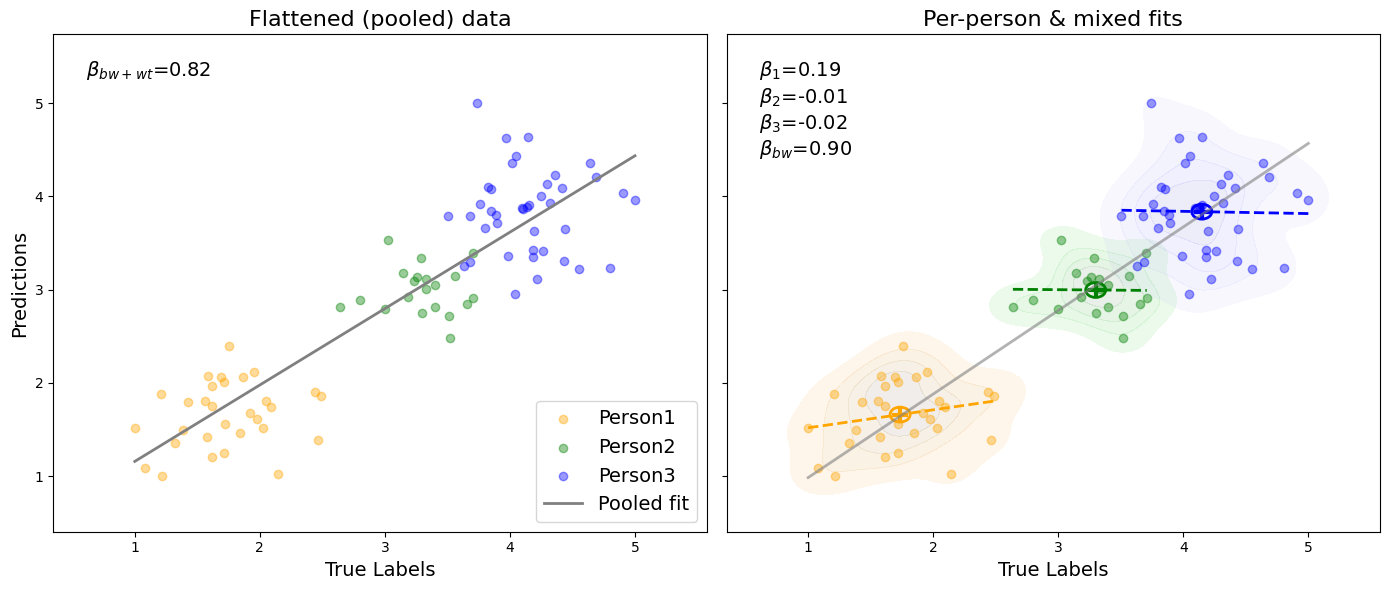

In [19]:
# ─── 2) PLOTTING ───────────────────────────────────────────────────────────────
palette   = ['orange','green','blue']
color_map = dict(zip(persons, palette))

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14,6), sharex=True, sharey=True)

# common x-range
x0, x1 = df['true'].min(), df['true'].max()
xx = np.array([x0, x1])

# ----- Left: Pooled -----
for p in persons:
    sub = df[df['person_id']==p]
    ax0.scatter(sub['true'], sub['pred'], color=color_map[p], alpha=0.4, label=p)

s_all, i_all, *_ = stats.linregress(df['true'], df['pred'])
ax0.plot(xx, i_all + s_all*xx, 'k-', lw=2, label='Pooled fit', color='gray')

ax0.set_title("Flattened (pooled) data", fontsize=fontsize_a)
ax0.set_xlabel("True Labels", fontsize=fontsize_b)
ax0.set_ylabel("Predictions", fontsize=fontsize_b)
ax0.legend(loc='lower right', fontsize=fontsize_b)
ax0.text(0.05, 0.95, rf"$\beta_{{bw+wt}}$={s_all:.2f}",
         transform=ax0.transAxes, va='top', fontsize=fontsize_b)

# ----- Right: Per-person & mixed fits -----
betas = {}

for p in persons:
    sub = df[df['person_id']==p]
    c   = color_map[p]

    # 1) seaborn 2D KDE fill
    sns.kdeplot(
    x=sub['true'], y=sub['pred'],
    levels=5,
    thresh=0.1,          # ignore super-low-density bleed
    fill=True,
    alpha=0.1,           # very subtle fill
    color=c,
    linewidths=1,        # optional: also draw edges
    ax=ax1, common_norm=False
    )

    # 2) scatter
    ax1.scatter(sub['true'], sub['pred'], color=c, alpha=0.4)

    # 3) per-person fit (dashed) over [min, max]
    s_p, i_p, *_ = stats.linregress(sub['true'], sub['pred'])
    betas[p] = s_p
    xp = np.array([sub['true'].min(), sub['true'].max()])
    ax1.plot(xp, i_p + s_p*xp, linestyle='--', color=c, lw=2)

    # # 4) within-person fit (dotted)
    # tc = sub['true'] - sub['true'].mean()
    # pc = sub['pred'] - sub['pred'].mean()
    # s_w, i_w, *_ = stats.linregress(tc, pc)
    # ax1.plot(xp, i_w + s_w*xp, linestyle=':', color=c, lw=2)

# between-person means and fit
means = df.groupby('person_id').agg(true=('true','mean'),
                                    pred=('pred','mean')).reset_index()

# choose a circle radius as a fraction of the x−range
radius = 0.02 * (x1 - x0)

for p in persons:
    m = means[means['person_id']==p]
    mx, my = m['true'].iloc[0], m['pred'].iloc[0]
     
    # 1) the plus marker
    ax1.scatter(mx, my,
                marker='+', s=120, linewidths=3,
                color=color_map[p])
    
    # 2) the surrounding circle
    circ = Circle(
        (mx, my),            # center
        radius,              # radius in data coords
        edgecolor=color_map[p],
        facecolor='none',
        linewidth=2
    )
    ax1.add_patch(circ)
    
    

s_bw, i_bw, *_ = stats.linregress(means['true'], means['pred'])
ax1.plot(xx, i_bw + s_bw*xx, color='gray', lw=2, alpha=0.6)

# annotate betas
txt = "\n".join([
    rf"$\beta_1$={betas['Person1']:.2f}",
    rf"$\beta_2$={betas['Person2']:.2f}",
    rf"$\beta_3$={betas['Person3']:.2f}",
    rf"$\beta_{{bw}}$={s_bw:.2f}",
    # rf"$\beta_{{wth}}$={s_w:.2f}",
])
ax1.text(0.05, 0.95, txt, transform=ax1.transAxes, va='top', fontsize=fontsize_b)

ax1.set_title("Per-person & mixed fits", fontsize=fontsize_a)
ax1.set_xlabel("True Labels", fontsize=fontsize_b)
ax1.legend([],[], frameon=False, fontsize=fontsize_b*2)

plt.tight_layout()
plt.show()